In [1]:
# Author: James Meehan
# Date: 8/15/2018
# Description: Machine Learning Model to Predict Fantasy Scores for NFL Quarterbacks on a weekly basis
# Cepheus Group Capstone

# import libraries
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
from sklearn import preprocessing

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# pull in data stack
df = pd.read_csv('AWSTFstack.csv', sep=',', header=None)
df = df.values

# pull in actual scores for training purposes
pts_target = pd.read_csv('output.csv', sep=',', header=None)

# Normalize the inputs
scaled_inputs = preprocessing.scale(df)
print(scaled_inputs)

samples_count = scaled_inputs.shape[0]

# separate into test and training samples
train_samples = int(0.8*samples_count)
test_samples = int(samples_count - train_samples)

train_inputs = scaled_inputs[:train_samples]
train_targets = pts_target[:train_samples]

test_inputs = scaled_inputs[train_samples:]
test_targets = pts_target[train_samples:]

[[ 0.44617255  1.02541799  0.15239653 ... -0.83934138 -0.56656537
  -0.35692569]
 [-0.91638412  1.02541799  1.70631619 ...  0.27779821 -0.62409691
  -0.35692569]
 [-1.73391812 -0.97521207  0.06569487 ... -0.83934138 -0.79669153
  -0.35692569]
 ...
 [-0.23510579 -0.97521207  0.06569487 ...  2.51207739 -0.56656537
  -0.35692569]
 [ 0.30991688  1.02541799  0.22197503 ... -0.83934138  1.50457012
  -0.35692569]
 [-1.05263978  1.02541799  0.2799571  ... -0.83934138  0.29640775
  -0.35692569]]


In [3]:
print("Training set: {}".format(train_inputs.shape))  # 1052 examples, 26 features
print("Testing set:  {}".format(test_inputs.shape))   # 263 examples, 26 features

Training set: (1052, 26)
Testing set:  (263, 26)


In [5]:
# create neural network.  Testing and refining showed a network with 1 hidden layer and 40 neurons provided the best results.
def build_model():
  model = keras.Sequential([
    keras.layers.Dense(40, activation=tf.nn.relu, 
                       input_shape=(train_inputs.shape[1],)),
    keras.layers.Dense(1)
  ])

  #AdamOptimizer
  optimizer = tf.train.AdamOptimizer(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
  return model

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 40)                1080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 41        
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Display training progress by printing a single dot for each completed epoch.
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 50

# Store training stats
history = model.fit(train_inputs, train_targets, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[PrintDot()])


..................................................

In [7]:
# Graph Training 
import matplotlib.pyplot as plt

def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(history.epoch, np.array(history.history['mean_absolute_error']), 
           label='Train Loss')
  plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
  plt.legend()
  plt.ylim([0,10])

plot_history(history)

In [8]:
# Get performance statistics (mean absolute error and mean squared error)
[loss, mae] = model.evaluate(test_inputs, test_targets, verbose=0)

print("Testing set Mean Abs Error: {:7.2f}".format(mae))
print("Testing set Mean Squared Error: {:7.2f}".format(loss))

Testing set Mean Abs Error:    7.73
Testing set Mean Squared Error:   98.42


In [9]:
# Get predictions
test_predictions = model.predict(test_inputs).flatten()

print(test_predictions)

[18.109758  14.971692  20.127531  23.116838  14.294641  21.805765
 15.241046  23.566725  13.576673  20.922209  22.642918  15.345474
 23.36544   19.533733  18.048052  23.727262  19.693747  20.279655
 14.105083  17.38933   19.187735  19.055979  15.548579  22.093588
 19.083467  14.860695  20.979841  15.296723  22.266863  14.465444
 14.778163  16.262651  28.746248  26.21101   22.674032  19.960003
 20.998543  17.648508  17.246298  19.737196  13.446845  22.062292
 18.556475  21.149097   9.896581  14.760594  16.588415  19.88053
 14.35756   19.638102  14.726292  26.528528  16.82946   25.710197
 25.169195  17.994413  12.577465  17.82521   18.857012  13.822724
 20.881744  18.392832  15.203069  20.138386  12.339669  20.945814
 15.5516815 22.161283  22.883257  21.268438  16.422777  23.598028
 14.970844  18.80223   15.81393   21.153437  23.480562  17.145369
 18.240227  11.2500925 19.345617  13.206643  12.913749  19.088264
 16.907812  23.252245  16.431683  19.654142  17.61044   25.471407
 18.624537 

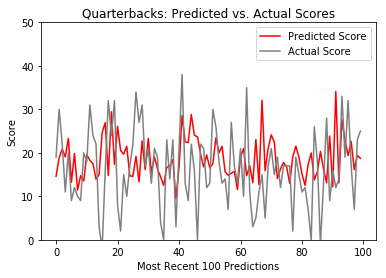

In [12]:
# Graph Predicted vs. Actual Scores
def plot_predict():
  plt.figure()
  plt.title('Quarterbacks: Predicted vs. Actual Scores')
  plt.xlabel('Most Recent 100 Predictions')
  plt.ylabel('Score')
  plt.plot(np.array(test_predictions[163:263]), label = "Predicted Score", color="red")
  plt.plot(np.array(test_targets[163:263]), label = "Actual Score", color="grey")
  plt.legend()
  plt.ylim([0,50])

plot_predict()

In [12]:
np.savetxt("predictions.csv", test_predictions, delimiter=",")

In [13]:
pts_target = pd.read_csv('output.csv', sep=',', header=None)

In [14]:
np.savetxt("predictionsTEST.csv", test_predictions, delimiter=",")

In [15]:
np.savetxt("actualScores.csv", test_targets, delimiter=",")

In [19]:
target_labels = pd.read_csv('labels.csv', sep=',', header=None)

In [20]:
test_labels = target_labels[train_samples + 1:]

In [29]:
test_labels.to_csv("predictLabels.csv", encoding='utf-8', index=False)

In [33]:
for a, b, c, d, x, y in zip(test_labels[0], test_labels[1], test_labels[2], test_labels[3], test_targets[0], test_predictions):
    print (a, b, c, d, x, y)
    

 Jay  Cutler 5 2017 7 20.616268
 Andy  Dalton 5 2017 15 21.668316
 Joe  Flacco 5 2017 8 20.694519
 Jared  Goff 5 2017 8 22.110083
 Brian  Hoyer 5 2017 26 13.8292465
 Case  Keenum 5 2017 13 22.697584
 DeShone  Kizer 5 2017 2 15.888918
 Eli  Manning 5 2017 18 22.776892
 Josh  McCown 5 2017 17 13.270284
 Cam  Newton 5 2017 32 18.993515
 Carson  Palmer 5 2017 17 22.470066
 Dak  Prescott 5 2017 35 19.924952
 Philip  Rivers 5 2017 26 26.963758
 Aaron  Rodgers 5 2017 29 22.106247
 Ben  Roethlisberger 5 2017 2 19.30422
 Alex  Smith 5 2017 31 22.233862
 Matthew  Stafford 5 2017 20 19.021454
 Tyrod  Taylor 5 2017 10 20.811659
 Deshaun  Watson 5 2017 45 14.463892
 Carson  Wentz 5 2017 35 19.63022
 Russell  Wilson 5 2017 12 22.728903
 Jameis  Winston 5 2017 20 23.871582
 Blake  Bortles 6 2017 14 12.86385
 Tom  Brady 6 2017 20 22.596973
 Jacoby  Brissett 6 2017 15 21.676294
 Jay  Cutler 6 2017 16 17.246012
 Joe  Flacco 6 2017 5 24.070454
 Jared  Goff 6 2017 10 19.179829
 Brian  Hoyer 6 2017 1 19.30

In [35]:
tester = [[a, b, c, d, x, y] for a, b, c, d, x, y in zip(test_labels[0], test_labels[1], test_labels[2], test_labels[3], test_targets[0], test_predictions)]
print(tester)

[[' Jay', ' Cutler', '5', '2017', 7, 20.616268], [' Andy', ' Dalton', '5', '2017', 15, 21.668316], [' Joe', ' Flacco', '5', '2017', 8, 20.694519], [' Jared', ' Goff', '5', '2017', 8, 22.110083], [' Brian', ' Hoyer', '5', '2017', 26, 13.8292465], [' Case', ' Keenum', '5', '2017', 13, 22.697584], [' DeShone', ' Kizer', '5', '2017', 2, 15.888918], [' Eli', ' Manning', '5', '2017', 18, 22.776892], [' Josh', ' McCown', '5', '2017', 17, 13.270284], [' Cam', ' Newton', '5', '2017', 32, 18.993515], [' Carson', ' Palmer', '5', '2017', 17, 22.470066], [' Dak', ' Prescott', '5', '2017', 35, 19.924952], [' Philip', ' Rivers', '5', '2017', 26, 26.963758], [' Aaron', ' Rodgers', '5', '2017', 29, 22.106247], [' Ben', ' Roethlisberger', '5', '2017', 2, 19.30422], [' Alex', ' Smith', '5', '2017', 31, 22.233862], [' Matthew', ' Stafford', '5', '2017', 20, 19.021454], [' Tyrod', ' Taylor', '5', '2017', 10, 20.811659], [' Deshaun', ' Watson', '5', '2017', 45, 14.463892], [' Carson', ' Wentz', '5', '2017',

In [44]:
import csv

In [51]:
with open("QBtestOutput.csv","w",newline="") as newFile: 
    cw = csv.writer(newFile)
    for list_ in tester:
        cw.writerow(list_)

In [56]:
# import training data
training_predictions = model.predict(train_inputs).flatten()
labels = target_labels
#training_predictions.shape
print(labels[337][1])
print(pts_target[0][336])

 Bortles
19


In [57]:
trainList = []

for i in range(337, 1052):
    mylist = []
    mylist.append(labels[i][0])
    mylist.append(labels[i][1])
    mylist.append(labels[i][2])
    mylist.append(labels[i][3])
    mylist.append(pts_target[0][i - 1])
    mylist.append(training_predictions[i])
    trainList.append(mylist)
print (trainList)

[[' Blake', ' Bortles', '3', '2015', 19, 15.655028], [' Sam', ' Bradford', '3', '2015', 10, 28.467506], [' Tom', ' Brady', '3', '2015', 26, 13.797078], [' Teddy', ' Bridgewater', '3', '2015', 2, 11.950466], [' Derek', ' Carr', '3', '2015', 24, 13.611513], [' Kirk', ' Cousins', '3', '2015', 16, 21.813133], [' Andy', ' Dalton', '3', '2015', 37, 9.278888], [' Ryan', ' Fitzpatrick', '3', '2015', 18, 21.607912], [' Joe', ' Flacco', '3', '2015', 24, 12.295449], [' Nick', ' Foles', '3', '2015', 6, 15.22055], [' Colin', ' Kaepernick', '3', '2015', 4, 20.181091], [' Andrew', ' Luck', '3', '2015', 20, 29.589306], [' Eli', ' Manning', '3', '2015', 23, 20.701817], [' Peyton', ' Manning', '3', '2015', 22, 21.445463], [' Marcus', ' Mariota', '3', '2015', 22, 21.835287], [' Cam', ' Newton', '3', '2015', 33, 25.245478], [' Carson', ' Palmer', '3', '2015', 22, 14.891982], [' Philip', ' Rivers', '3', '2015', 12, 21.656733], [' Aaron', ' Rodgers', '3', '2015', 44, 17.083145], [' Ben', ' Roethlisberger', 

In [58]:
import csv
from pandas import read_csv 

with open("QBtrainOutput.csv","w",newline="") as newFile: 
    cw = csv.writer(newFile, delimiter=',')
    for i in trainList:
        cw.writerow(i)
        
QBformat = read_csv('QBtrainOutput.csv', sep=',')
QBformat.columns = ['fname', 'lname', 'week', 'yr', 'actual', 'predicted']
        
QBformat.to_csv('QBtrainOutput.csv', index=False)

In [59]:
import psycopg2
conn = psycopg2.connect(database="Cepheus_db",
                        user="db_usr",
                        password="B3av3rs1!",
                        host="osucepheus.cgwruhobay1w.us-east-2.rds.amazonaws.com",
                        port="5432")

In [60]:
# put training predict data into database
#Create cursor with which to execute queries
cur = conn.cursor()

#parse csv
with open ('QBtrainOutput.csv') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=',')
    for row in reader:
        #build query string
        query1 = 'INSERT INTO qb_results(fname, lname, week, yr, actual, predicted) VALUES '
        query2 =row['fname'], row['lname'], row['week'], row['yr'], row['actual'], row['predicted']
        query = str(query1) + str(query2)
        print(query)
        #execute query
        cur.execute(query)
#commit change
conn.commit()

INSERT INTO qb_results(fname, lname, week, yr, actual, predicted) VALUES (' Sam', ' Bradford', '3', '2015', '10', '28.467506')
INSERT INTO qb_results(fname, lname, week, yr, actual, predicted) VALUES (' Tom', ' Brady', '3', '2015', '26', '13.797077999999999')
INSERT INTO qb_results(fname, lname, week, yr, actual, predicted) VALUES (' Teddy', ' Bridgewater', '3', '2015', '2', '11.950466')
INSERT INTO qb_results(fname, lname, week, yr, actual, predicted) VALUES (' Derek', ' Carr', '3', '2015', '24', '13.611513')
INSERT INTO qb_results(fname, lname, week, yr, actual, predicted) VALUES (' Kirk', ' Cousins', '3', '2015', '16', '21.813132999999997')
INSERT INTO qb_results(fname, lname, week, yr, actual, predicted) VALUES (' Andy', ' Dalton', '3', '2015', '37', '9.278888')
INSERT INTO qb_results(fname, lname, week, yr, actual, predicted) VALUES (' Ryan', ' Fitzpatrick', '3', '2015', '18', '21.607912')
INSERT INTO qb_results(fname, lname, week, yr, actual, predicted) VALUES (' Joe', ' Flacco',

INSERT INTO qb_results(fname, lname, week, yr, actual, predicted) VALUES (' Philip', ' Rivers', '13', '2015', '6', '23.816035999999997')
INSERT INTO qb_results(fname, lname, week, yr, actual, predicted) VALUES (' Aaron', ' Rodgers', '13', '2015', '28', '17.816595')
INSERT INTO qb_results(fname, lname, week, yr, actual, predicted) VALUES (' Matt', ' Ryan', '13', '2015', '14', '19.221378')
INSERT INTO qb_results(fname, lname, week, yr, actual, predicted) VALUES (' Alex', ' Smith', '13', '2015', '28', '26.120375')
INSERT INTO qb_results(fname, lname, week, yr, actual, predicted) VALUES (' Matthew', ' Stafford', '13', '2015', '21', '17.944647')
INSERT INTO qb_results(fname, lname, week, yr, actual, predicted) VALUES (' Ryan', ' Tannehill', '13', '2015', '10', '18.030542')
INSERT INTO qb_results(fname, lname, week, yr, actual, predicted) VALUES (' Tyrod', ' Taylor', '13', '2015', '34', '33.503544')
INSERT INTO qb_results(fname, lname, week, yr, actual, predicted) VALUES (' Russell', ' Wilso

INSERT INTO qb_results(fname, lname, week, yr, actual, predicted) VALUES (' Marcus', ' Mariota', '6', '2016', '33', '18.237913')
INSERT INTO qb_results(fname, lname, week, yr, actual, predicted) VALUES (' Brock', ' Osweiler', '6', '2016', '20', '14.573279000000001')
INSERT INTO qb_results(fname, lname, week, yr, actual, predicted) VALUES (' Dak', ' Prescott', '6', '2016', '24', '14.806087')
INSERT INTO qb_results(fname, lname, week, yr, actual, predicted) VALUES (' Philip', ' Rivers', '6', '2016', '13', '28.352771999999998')
INSERT INTO qb_results(fname, lname, week, yr, actual, predicted) VALUES (' Ben', ' Roethlisberger', '6', '2016', '11', '24.379694')
INSERT INTO qb_results(fname, lname, week, yr, actual, predicted) VALUES (' Matt', ' Ryan', '6', '2016', '28', '23.88516')
INSERT INTO qb_results(fname, lname, week, yr, actual, predicted) VALUES (' Matthew', ' Stafford', '6', '2016', '35', '14.691867000000002')
INSERT INTO qb_results(fname, lname, week, yr, actual, predicted) VALUES 

INSERT INTO qb_results(fname, lname, week, yr, actual, predicted) VALUES (' Andrew', ' Luck', '16', '2016', '28', '14.406751000000002')
INSERT INTO qb_results(fname, lname, week, yr, actual, predicted) VALUES (' Eli', ' Manning', '16', '2016', '14', '20.12358')
INSERT INTO qb_results(fname, lname, week, yr, actual, predicted) VALUES (' Marcus', ' Mariota', '16', '2016', '9', '23.460844')
INSERT INTO qb_results(fname, lname, week, yr, actual, predicted) VALUES (' Cam', ' Newton', '16', '2016', '12', '15.692174')
INSERT INTO qb_results(fname, lname, week, yr, actual, predicted) VALUES (' Carson', ' Palmer', '16', '2016', '17', '24.446367000000002')
INSERT INTO qb_results(fname, lname, week, yr, actual, predicted) VALUES (' Dak', ' Prescott', '16', '2016', '29', '23.881496')
INSERT INTO qb_results(fname, lname, week, yr, actual, predicted) VALUES (' Philip', ' Rivers', '16', '2016', '22', '20.588238')
INSERT INTO qb_results(fname, lname, week, yr, actual, predicted) VALUES (' Aaron', ' Ro